In [3]:
import numpy as np
import pandas as pd
import pygwalker as pyg
import seaborn as sb
from scipy.linalg import cholesky
import matplotlib.pyplot as plt



In [4]:
data = np.random.randint(2, size=(2,1000))
print(data)
cov = np.cov(data)
print(cov)

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(cov, dtype=bool))

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
# cmap = sb.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
# sb.heatmap(cov, mask=mask, cmap=cmap, vmax=.3, center=0,
 #           square=True, linewidths=.5, cbar_kws={"shrink": .5})

[[0 0 0 ... 0 1 0]
 [1 1 1 ... 1 1 1]]
[[0.24831231 0.0004004 ]
 [0.0004004  0.24962462]]


In [5]:
synthetic_data = np.random.multivariate_normal([0,0], cov, 500)
#synthetic_data+=0.5

# Noise, I can do that
# Joel. before his language test
synthetic_data

array([[ 3.42623208e-01, -7.23008241e-01],
       [ 8.24847204e-01, -4.42463548e-01],
       [ 5.70069545e-01,  1.11114403e+00],
       [-1.01472025e+00, -7.43261006e-02],
       [-4.56564153e-02,  5.78771867e-01],
       [-5.63527433e-02,  5.94451655e-01],
       [-5.83589788e-01,  1.74343421e-01],
       [-4.08286908e-01, -1.69610714e+00],
       [-3.10187256e-02,  5.67140396e-01],
       [ 3.21277792e-01,  5.52576135e-01],
       [ 6.17645854e-01,  4.37543573e-01],
       [ 2.48624481e-01,  4.22191782e-01],
       [-5.69952314e-01, -1.58673330e-01],
       [ 5.12682321e-02,  7.01696396e-01],
       [-5.62483771e-01, -7.23653339e-02],
       [ 3.55085009e-01, -8.95272938e-01],
       [ 1.22306255e-01, -5.73935306e-01],
       [ 1.21548683e+00,  5.88254927e-01],
       [ 4.09223146e-02, -2.79222642e-01],
       [ 6.60734177e-02, -6.78393050e-01],
       [-8.08249797e-02,  5.79187900e-01],
       [-2.85830023e-01, -1.97975981e-01],
       [-6.37737139e-01, -1.50967811e-01],
       [-8.

In [ ]:
df1 = pd.DataFrame(data.T, columns=["x", "y"])
df2 = pd.DataFrame(synthetic_data, columns=["x","y"])
#df1["col"]="blue"
#df2["col"]="red"
df = pd.concat([
    df1,df2])
print(df)

# sb.scatterplot(data=df,x="x",y="y",c=df["col"]).plot()
sb.jointplot(data=df, x="x", y="y", hue="col")

[[-0.9459319961753467], [-2.0032616602497506]]
row[[-1.36202646 -1.36202646]
 [-2.21214533 -2.21214533]]
[[-2.72405291]
 [-4.42429066]]
[[1.3746894785089685], [-1.5076867992615992]]
row[[ 0.50724701  0.50724701]
 [-1.81332639 -1.81332639]]
[[-0.679826728997049], [-0.9431923394682381]]
row[[-1.14763654 -1.14763654]
 [-1.35904369 -1.35904369]]
[[0.9312201264255409], [0.19364171293989735]]
row[[ 0.15010276  0.15010276]
 [-0.44416485 -0.44416485]]
[[0.5674619846421811], [0.4092388858811859]]
row[[-0.14289455 -0.14289455]
 [-0.27066082 -0.27066082]]
[[0.3902275350952012], [0.15129696406651436]]
row[[-0.2856668  -0.2856668 ]
 [-0.47824222 -0.47824222]]
[[0.15677244869107637], [-0.1697204922023721]]
row[[-0.47372716 -0.47372716]
 [-0.7365843  -0.7365843 ]]
[[0.4451748536155256], [-0.6343435317001967]]
row[[-0.24143874 -0.24143874]
 [-1.11049445 -1.11049445]]
[[0.5173375377719343], [0.2078237106742402]]
row[[-0.1832778  -0.1832778 ]
 [-0.43275174 -0.43275174]]
[[0.6702747416831552], [0.1210817

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


[[-0.43245506220581614], [-1.1489133711385282]]
row[[-0.94838776 -0.94838776]
 [-1.5245998  -1.5245998 ]]
[[1.2431642426237426], [0.19081695704146406]]
row[[ 0.40137266  0.40137266]
 [-0.4464381  -0.4464381 ]]
[[-2.216763983020302], [-0.02236401002338994]]
row[[-2.3855974  -2.3855974 ]
 [-0.61799767 -0.61799767]]
[[-1.9499782624072355], [1.134637792856606]]
row[[-2.17065545 -2.17065545]
 [ 0.31311138  0.31311138]]
[[-0.8754218264124635], [0.04828400151530884]]
row[[-1.3051476  -1.3051476 ]
 [-0.56114296 -0.56114296]]
[[0.3452440163023842], [0.07369740944981985]]
row[[-0.32190403 -0.32190403]
 [-0.54069126 -0.54069126]]
[[-1.6680702223698771], [1.0139137736955006]]
row[[-1.94358429 -1.94358429]
 [ 0.21595749  0.21595749]]
[[0.1128332837229303], [0.30255100972944]]
row[[-0.50910088 -0.50910088]
 [-0.35651898 -0.35651898]]
[[0.6860301747528847], [-0.26672986173661195]]
row[[-0.04741564 -0.04741564]
 [-0.81465359 -0.81465359]]
[[-0.3232352777497354], [-1.871644567536147]]
row[[-0.86044085 

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Mean x: -0.5926
Mean y: -0.5936


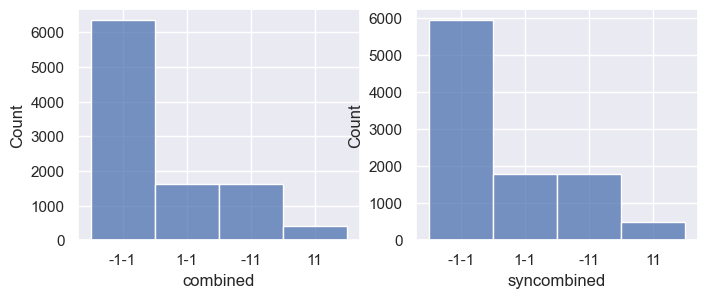

In [19]:
def synRow(mean, L):
    y = [[np.random.normal(0)], [np.random.normal(0)]]
    # y = np.random.choice(np.arange(-1,2), size=(2,1), p=[0.5,0,0.5])
    print(y)
#    np.sum([np.matmul(L,y), mean], axis=1)
    row = (np.matmul(L, y) + mean)
    print("row" + str(row))
    # Transposing 1D matrix
    return row.sum(axis=1).reshape(-1,1)
#    synthetic_data = np.c_[synthetic_data, synRow.T]

DATA_SIZE, SAMPLE_SIZE = (10000, 10000)
dims = 2
shape = (dims,DATA_SIZE)
(p1, p2) = 0.8, 0.2
data = np.random.choice(np.arange(-1,2), size=shape, p=[p1,0, p2])
mean = np.array([p1*-1+p2*1, p1*-1+p2*1])

cov = np.cov(data, bias = True)
L = cholesky(cov)
synthetic_data = np.array(synRow(mean, L))
print(synthetic_data)

## Creating Synthetic data
for i in range(SAMPLE_SIZE-1):
    synthetic_data = np.append(synthetic_data,synRow(mean, L), axis=1)

print(synthetic_data)
df1 = pd.DataFrame(data.T, columns=["x", "y"])
df2 = pd.DataFrame(synthetic_data.T, columns=["x","y"])\
    .applymap(lambda x: (-1 if x < 0 else 1))
print(df2)
df = pd.concat([df1,df2])

df1['combined'] = df1['x'].astype(str) + df1['y'].astype(str)
df2['syncombined'] = df2['x'].astype(str) + df2['y'].astype(str)
print(cov)

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above)
sb.set(style="darkgrid")

fig, axs = plt.subplots(1, 2, figsize=(8, 3))
sb.histplot(data = df1['combined'],  bins = 4, ax=axs[0])
sb.histplot(data = df2['syncombined'],  bins = 4, ax=axs[1])
print("Mean x: " + str(df1['x'].mean()))
print("Mean y: " + str(df1['y'].mean()))

## Problems: If there was no sample drawn from the covariance matrix, then there will also be no sample in our resulting matrix

In [ ]:
pyg.walk(data)